# Лабораторная работа 3
### Выполнил: Баютов Александр Владимирович

Добро пожаловать в третью лабораторную работу! 
Оформите ваше решение контеста Kaggle в соответствии с этим шаблоном. Ваша задача - показать проверяющим ход ваших рассуждений, поэтому советуем писать много комментариев к коду и приводить комментарии к логике на каждом этапе в текстовых ячейках. 
Где необходимо, используйте графики для большей наглядности.

При отправке поменяйте название файла на ваши ФИО!

### Настройка Google Colab

Подключение вашего гугл диска (советуем сохранять все важные артефакты именно на диск, чтобы они не удалились при закрытии вкладки с ноутбуком).

In [19]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

Если вы используете google colab и загрузка датасета занимает больше минуты - раскомментируйте и выполните эту ячейку.

In [20]:
# import json
# import os

# def download_contest3_data():
#   # !mkdir ~/.kaggle # закоментить если ругается
#   # !touch ~/.kaggle/kaggle.json # закоментить если ругается

#   # токен надо сгенерировать в личном кабинете на kaggle (https://www.kaggle.com/settings/account)
#   api_token = {"username":"fokuspokus","key":"abrakadabra"}
#   with open('/root/.kaggle/kaggle.json', 'w') as file:
#       json.dump(api_token, file)

#   !chmod 600 ~/.kaggle/kaggle.json

#   !kaggle competitions download -p /content/drive/MyDrive/ -c ml-mipt-2023-contest-3

#   if not os.path.isdir("/content/drive/MyDrive/contest3"):
#     !mkdir /content/drive/MyDrive/contest3

#   !unzip /content/drive/MyDrive/ml-mipt-2023-contest-3.zip -d /content/drive/MyDrive/contest3

# download_contest3_data()

### EDA (исследовательский анализ данных)

В этой лабораторной вы работаете с картинками. Напишите функцию, которая отрисовывала бы ключевые точки на конкретном изображении, это вам пригодится для дебага. 
Можете посчитать статистики по картинкам в датасете.

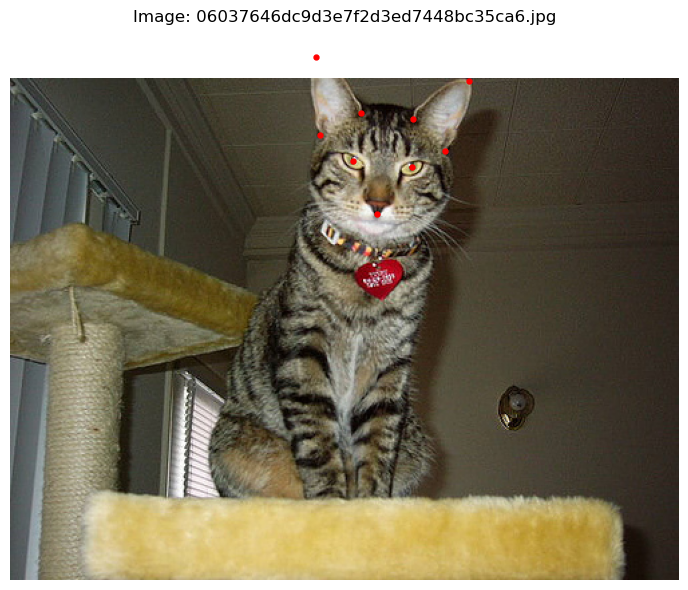

In [47]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

config = {
    'img_dir': 'Downloads/ml-mipt-2024-contest-3/images/images/train',
    'labels': 'Downloads/ml-mipt-2024-contest-3/train_labels.csv'
}

def load_dataset():
    labels_data = pd.read_csv(config['labels'])
    valid_images = [f for f in os.listdir(config['img_dir']) 
                   if f.lower().endswith(('png', 'jpg', 'jpeg')) and 
                   os.path.isfile(os.path.join(config['img_dir'], f))]
    return labels_data[labels_data['file_name'].isin(valid_images)]

def display_image_with_points(idx, dataframe):
    sample = dataframe.iloc[idx]
    img_path = os.path.join(config['img_dir'], sample['file_name'])
    
    with Image.open(img_path) as img:
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        
        coords = np.array(sample.drop('file_name')).reshape((-1, 2))
        plt.scatter(
            x=coords[:, 0], 
            y=coords[:, 1],
            marker='.',
            c='red',
            s=50,
        )
        
        plt.title(f"Image: {sample['file_name']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

df = load_dataset()
display_image_with_points(10, processed_data)

Отрицательные координаты вызвали сомнения, но просмотр этого изображения показывает, что они верно обозначают положение уха за краем картинки

### Preprocessing (подготовка данных)

Мы ожидаем, что в этом разделе вы реализуете кастомный класс для подгрузки данных (cоветуем унаследоваться от `torch.utils.data.Dataset`).

In [21]:
import PIL
from PIL import Image
from collections import Counter
from torch.utils.data import Dataset
from torchvision.transforms.v2 import Compose

IMAGE_SIZE = (128, 128)

transform = Compose([
    T.Resize(IMAGE_SIZE),
    T.ToImage(),
    T.ToDtype(torch.float, scale=True),
])

class CatKeypointsDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, file_names, labels_df=None, transforms=None):
        self.images_dir = images_dir
        self.transforms = transforms
        self.file_names = file_names
        self.labels_df = labels_df

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.file_names[idx])
        image = Image.open(img_name).convert("RGB")
        original_size = image.size

        if self.transforms:
            image = self.transforms(image)

        if self.labels_df is not None:
            keypoints = self.labels_df[self.labels_df['file_name'] == self.file_names[idx]].iloc[0, :-1].values.astype('float32').reshape(-1, 2)

            keypoints[:, 0] = keypoints[:, 0] / original_size[0] * IMAGE_SIZE[0]
            keypoints[:, 1] = keypoints[:, 1] / original_size[1] * IMAGE_SIZE[1]

            return image, torch.tensor(keypoints).flatten()
        else:
            return image, self.file_names[idx]



### Training/evaluation loop

В этом разделе напишите функцию, принимающую модель, оптимизатор, кол-во эпох, и т.д, которая осуществляет обучение с заданными параметрами. Подумайте, что функция будет возвращать. 

Смысл этого раздела в том, чтобы не дублировать код обучения для каждого эксперимента. А еще на такую функцию легко накинуть перебор гиперпараметров... 

In [22]:
### function for training


def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device="cpu"):
    model.to(device)

    l1_history_train = []
    l1_history_val = []

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        epoch_l1_train = 0
        with tqdm(train_dataloader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs} [Train]") as tepoch:
            for batch_idx, (data, target) in enumerate(tepoch):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                epoch_l1_train += loss.item()

                tepoch.set_postfix(l1=loss.item())

        l1_history_train.append(epoch_l1_train / len(train_dataloader))

        # Валидация
        model.eval()
        epoch_l1_val = 0
        with torch.no_grad():
            with tqdm(val_dataloader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs} [Val]") as vepoch:
                for batch_idx, (data, target) in enumerate(vepoch):
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)

                    epoch_l1_val += loss.item()

                    vepoch.set_postfix(l1=loss.item())

        l1_history_val.append(epoch_l1_val / len(val_dataloader))

        # График
        clear_output(wait=True)
        plt.plot(l1_history_train, label='Train L1')
        if l1_history_val:
            plt.plot(l1_history_val, label='Validation L1')
        plt.title('L1 Loss')
        plt.legend()
        plt.show()

        print(f"Epoch: {epoch+1}/{num_epochs}, Train L1: {l1_history_train[-1]:.4f}")
        if l1_history_val:
            print(f"Validation L1: {l1_history_val[-1]:.4f}")

    return {
        "train_l1": l1_history_train,
        "val_l1": l1_history_val,
    }

### Prediction function

Реализуйте функцию, которая бы делала предсказания. Функция принимает датасет/даталоадер и модель (мб еще что-то). Эта функция нужна вам, чтобы было удобнее считать метрику (по сути она будет склеивать предсказания из батчей в один массив). 

In [23]:
### function for making predictions

def predict(model, dataloader, device="cuda"):
    model.to(device)
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc="Predicting"):
            data = data.to(device)
            output = model(data)
            all_predictions.append(output.cpu().numpy())

    return np.concatenate(all_predictions, axis=0)

### Experiments

В этом разделе задаете архитектуры моделей и ставите эксперименты по обучению. Мы ожидаем, что вы зададите модель в виде класса (унаследуетесь от класса `torch.nn.Module`).

Если вы ставили много экспериментов, приведите их в хронологическом порядке, чтобы мы увидели эволюцию ваших рассуждений. 

Мы ожидаем увидеть графики train/val лоссов и метрик для ваших экспериментов. Мы ожидаем увидеть визуализацию примеров предсказаний. 

#### Эксперимент 1

Для начала решил попробовать обычную CNN

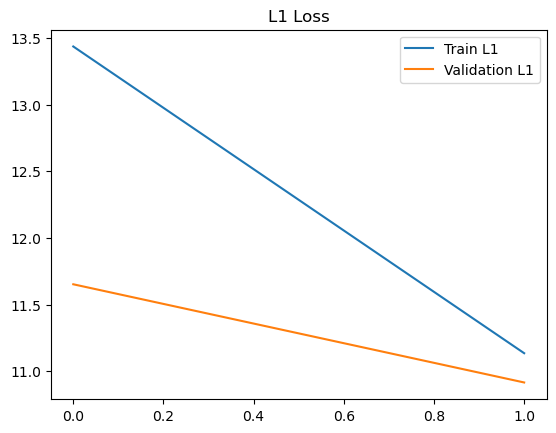

Epoch: 2/2, Train L1: 11.1351
Validation L1: 10.9155
CPU times: total: 30min 50s
Wall time: 3min 53s


In [48]:
%%time
# some code and comments
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as T
from PIL import Image
import os
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import pandas as pd
from sklearn.model_selection import train_test_split

class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 18)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_EPOCHS = 2
LEARNING_RATE = 1e-3


# Разделение тренировочного датасета на тренировочный и валидационный
train_images, val_images, train_labels, val_labels = train_test_split(
    df['file_name'].tolist(),
    df,
    test_size=0.2,
    random_state=42
)

train_data = CatKeypointsDataset(config['img_dir'], train_images, train_labels, transforms=transform)
val_data = CatKeypointsDataset(config['img_dir'], val_images, val_labels, transforms=transform)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Инициализация модели, функции потерь и оптимизатора:

model = BasicCNN()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Запуск обучения
device = "cpu"
training_history = train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    NUM_EPOCHS,
    device=device
)

Predicting: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:16<00:00,  3.37it/s]


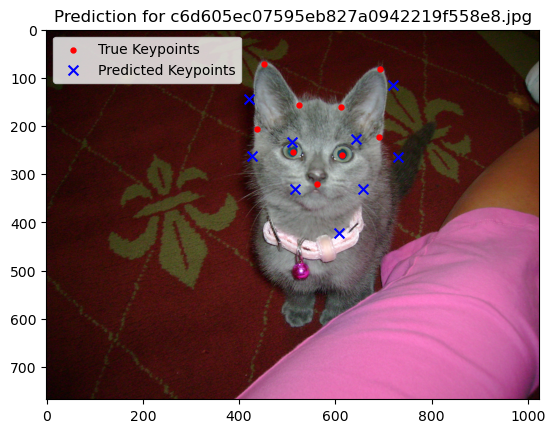

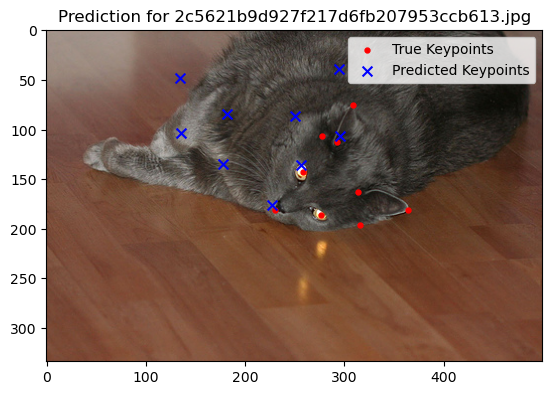

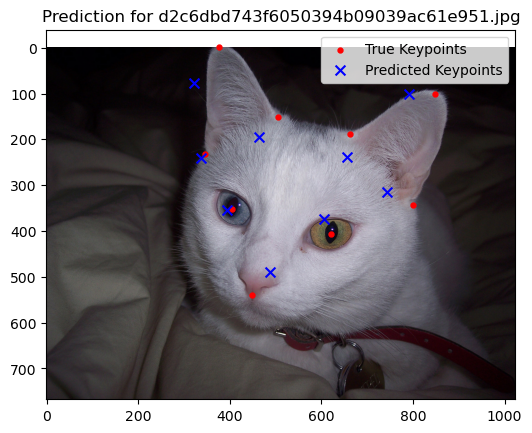

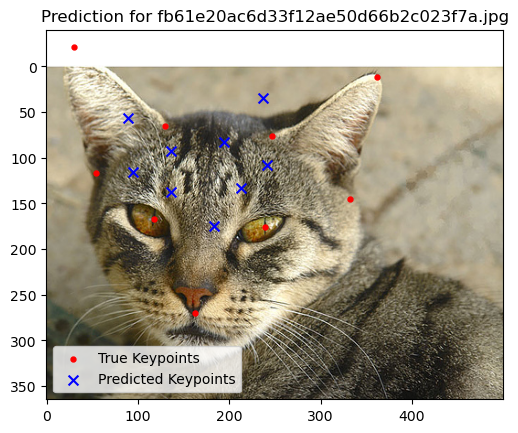

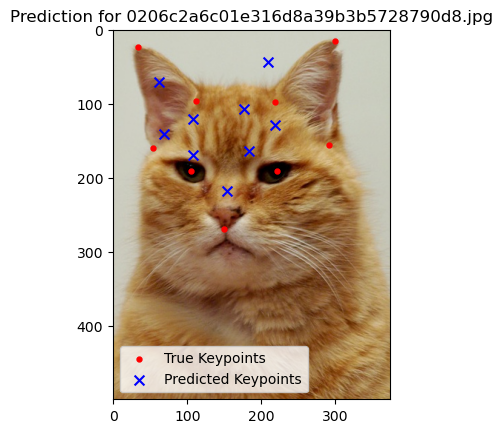

In [49]:
def plot_predicted_keypoints(image_index, true_df, predicted_keypoints, images_dir):
    row = true_df.iloc[image_index]
    image_name = row['file_name']
    true_keypoints = row[:-1].values.tolist()
    image_path = os.path.join(images_dir, image_name)

    image = Image.open(image_path)
    original_width, original_height = image.size
    plt.imshow(image, cmap='gray')

    true_keypoints = np.array(true_keypoints).reshape(-1, 2)
    plt.scatter(true_keypoints[:, 0], true_keypoints[:, 1], s=50, marker='.', c='red', label='True Keypoints')

    predicted_kpts_scaled = predicted_keypoints[image_index].reshape(-1, 2)

    predicted_kpts_original_scale = predicted_kpts_scaled.copy()
    predicted_kpts_original_scale[:, 0] = predicted_kpts_scaled[:, 0] / IMAGE_SIZE[0] * original_width
    predicted_kpts_original_scale[:, 1] = predicted_kpts_scaled[:, 1] / IMAGE_SIZE[1] * original_height

    plt.scatter(predicted_kpts_original_scale[:, 0], predicted_kpts_original_scale[:, 1], s=50, marker='x', c='blue', label='Predicted Keypoints')

    plt.title(f"Prediction for {image_name}")
    plt.legend()
    plt.show()
    
import random

num_samples_to_visualize = 5

random_indices = random.sample(range(num_val_samples), num_samples_to_visualize)
predicted_keypoints_val = predict(model, val_dataloader, device=device)

for i in random_indices:
    plot_predicted_keypoints(i, val_labels, predicted_keypoints_val, config['img_dir'])

Я не стал её долго обучать, тем не менее, этой модели удалось предолеть baseline на kaggle, но там loss получился примерно в 5 раз больше, т.к. сейчас он считается на картинках приведённых к размеру 128х128, что гараздо меньше оригинальных.

#### Эксперимент 2

Далее я решил попробовать UNet

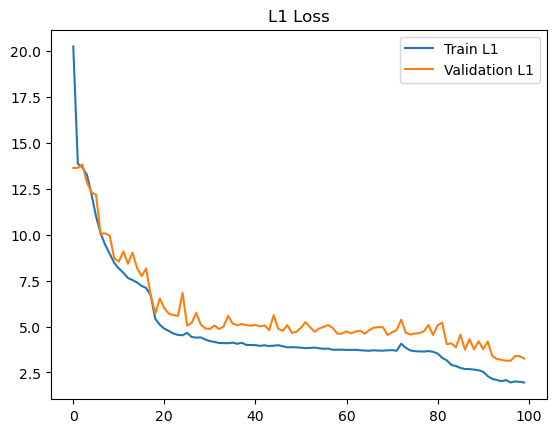

Epoch: 100/100, Train L1: 1.9530
Validation L1: 3.2583
CPU times: total: 1d 17h 26min 9s
Wall time: 7h 14min 28s


In [12]:
%%time
# some code and comments
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as T
from PIL import Image
import os
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import pandas as pd
from sklearn.model_selection import train_test_split

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, input_channels=3, num_keypoints=9):
        super().__init__()
        self.num_keypoints = num_keypoints

        # downsampling
        self.enc1 = DoubleConv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # upsampling
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_keypoints * 2)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        x = self.global_pool(d1) 
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 1e-2

model = UNet()
criterion_exp1 = nn.L1Loss()
optimizer_exp1 = torch.optim.Adam(model_exp1.parameters(), lr=LEARNING_RATE)

# Запуск обучения
device = "cuda" if torch.cuda.is_available() else "cpu"
training_history = train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    NUM_EPOCHS,
    device=device
)

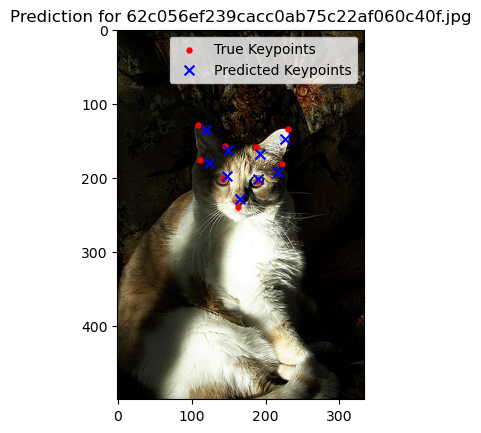

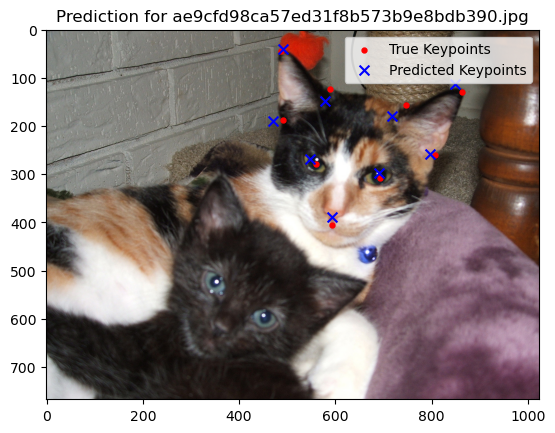

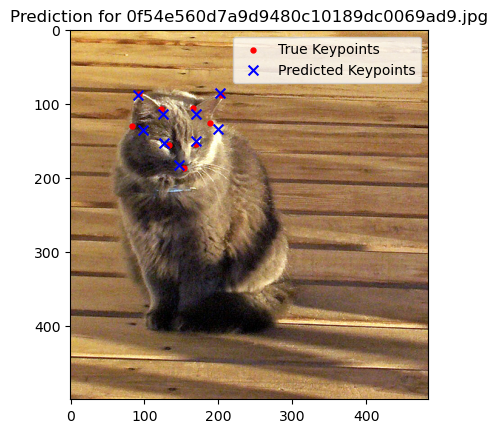

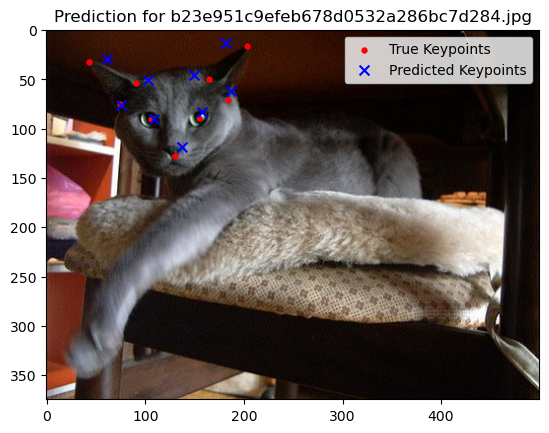

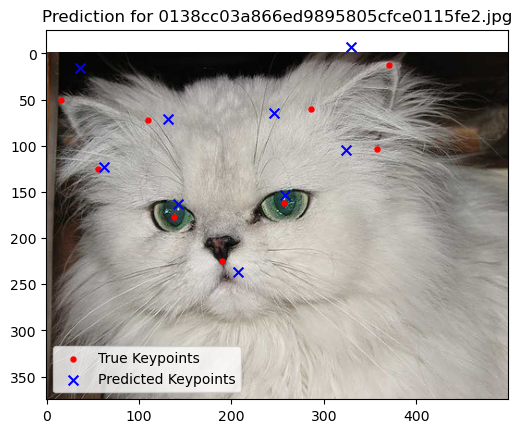

In [18]:
num_samples_to_visualize = 5
num_val_samples = len(val_labels_exp1)
num_samples_to_visualize = min(num_samples_to_visualize, num_val_samples)

random_indices = random.sample(range(num_val_samples), num_samples_to_visualize)

for i in random_indices:
    plot_predicted_keypoints(i, val_labels, predicted_keypoints_val, config['img_dir'])

UNet гараздо точнее CNN, т.к. для предсказания точек важна информация об исходном изображении, но она долго обучалась, поэтому я не успел до дейдлайна на kaggle

#### Эксперимент 3

In [38]:
# some code and comments

### Evaluation  (оценка качества модели)

В этом разделе проводите оценку качества вашей итоговой модели (с помощью prediction function из раздела выше). 

In [14]:
# model evaluation
predicted_keypoints_val = predict(model, val_dataloader, device=device)
true_keypoints_val = np.concatenate([y.numpy() for _, y in val_dataloader], axis=0)
l1_loss_val_predictions = nn.functional.l1_loss(torch.tensor(predicted_keypoints_val), torch.tensor(true_keypoints_val)).item()
print(f"L1 Loss на валидационном наборе (Experiment 1): {l1_loss_val_predictions:.4f}")

Predicting: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:35<00:00,  1.59it/s]


L1 Loss на валидационном наборе (Experiment 1): 3.2712


### Conclusion (Выводы)

В этом разделе описываете полученные результаты и проводите анализ выполненной работы. 
Что получилось / не получилось и почему?

С помощью простой CNN, удалось преодолеть baseline. UNet справилась с задачей лучше, но долго обучалась из-за большого колличества параметров.